<a href="https://colab.research.google.com/github/xharles2994/Tensorflow_models/blob/main/TITLE_CV_Binary_Semantic_Segmentation_using_U_Net__A_Deep_Learning_Approach_for_Road_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title: Multiclass Semantic Segmentation of Minerals in Soil Samples using U-Net with MobileVNet Backbone

##Table of Contents:

1. Introduction

2. Problem Statement

3. Method

 3.1 Dataset Preparation

 3.2 Model Architecture

 3.3 Training and Evaluation

4. Results and Analysis

5. Conclusion and Future Work

6. References (if applicable)


##2. Problem Statement:

Problem Statement: The problem is binary image segmentation of road images in the Massachusetts Roads Dataset. The objective is to accurately classify pixels in the images as either road or non-road, effectively segmenting the road areas. The dataset contains high-resolution images with dimensions of 1500x1500 pixels.

Data source: dataset is obtained from Kaggle link https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset/code?select=metadata.csv

Objective:
The objective is to develop a binary image segmentation model using U-Net to identify and segment roads in the Massachusetts Roads Dataset. The model will be trained to classify each pixel in the images as road or non-road. By accurately segmenting the road areas, the model can assist in various applications, such as urban planning, transportation management, and infrastructure development.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Dependencies



In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Dataset Preparation:
Preprocessing and Cropping:
To prepare the images for training the U-Net model, the images need to be resized from their original dimensions of 1500x1500 pixels to a smaller size of 256x256 pixels. This resizing is performed to reduce the computational complexity and memory requirements during training. Cropping is used to maintain the central region of the image while discarding the surrounding areas. The cropping process ensures that the important road features are preserved while removing unnecessary background information.

The steps for preprocessing and cropping the images can be implemented using various image processing libraries, such as OpenCV or scikit-image. These libraries provide functions to resize and crop images to the desired dimensions. After resizing and cropping, the images are ready to be preprocessed further, such as normalization, data augmentation, or any other required preprocessing steps, before training the U-Net model.

Once the images are preprocessed, they can be used to train the U-Net model for binary image segmentation of roads. The U-Net architecture is well-suited for this task as it can capture both local and global features, enabling accurate segmentation of road areas. By training the model on the Massachusetts Roads Dataset, the objective of accurately segmenting roads can be achieved

In [ ]:
import os
import cv2
import numpy as np
from patchify import patchify
import glob

CROPPING IMAGES


In [ ]:
def sort_and_crop_images(image_directory, output_folder):
    # Create a directory to store the cropped images
    cropped_images_folder = os.path.join(output_folder, 'cropped_images')
    os.makedirs(cropped_images_folder, exist_ok=True)

    # Get a list of all image files in the image directory
    image_files = glob.glob(os.path.join(image_directory, "*.tiff"))
    image_files.sort()

    total_cropped_images = 0

    for i, image_file in enumerate(image_files):
        # Load the image
        image = cv2.imread(image_file)

        # Crop the image to the nearest size divisible by 256
        height, width = image.shape[:2]
        width = (width // 256) * 256
        height = (height // 256) * 256
        image = image[:height, :width, :]

        # Divide the cropped image into patches of 256x256x3
        image_patches = patchify(image, (256, 256, 3), step=256)

        # Save each image patch as a separate file
        for a in range(image_patches.shape[0]):
            for b in range(image_patches.shape[1]):
                image_patch = image_patches[a, b, 0, :, :, :]  # Get the first channel of the patch

                image_patch_filename = f"image_patch_{i}_{a}_{b}.png"
                image_patch_filepath = os.path.join(cropped_images_folder, image_patch_filename)
                cv2.imwrite(image_patch_filepath, image_patch)

                total_cropped_images += 1

        print(f"Image {i+1}/{len(image_files)} cropped and saved successfully.")

    print(f"Total number of cropped images: {total_cropped_images}")

# Specify the image directory and output folder
image_directory = '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/test/'
output_folder = '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/'

# Call the function to sort and crop the images
sort_and_crop_images(image_directory, output_folder)


Image 1/103 cropped and saved successfully.
Image 2/103 cropped and saved successfully.
Image 3/103 cropped and saved successfully.
Image 4/103 cropped and saved successfully.
Image 5/103 cropped and saved successfully.
Image 6/103 cropped and saved successfully.
Image 7/103 cropped and saved successfully.
Image 8/103 cropped and saved successfully.
Image 9/103 cropped and saved successfully.
Image 10/103 cropped and saved successfully.
Image 11/103 cropped and saved successfully.
Image 12/103 cropped and saved successfully.
Image 13/103 cropped and saved successfully.
Image 14/103 cropped and saved successfully.
Image 15/103 cropped and saved successfully.
Image 16/103 cropped and saved successfully.
Image 17/103 cropped and saved successfully.
Image 18/103 cropped and saved successfully.
Image 19/103 cropped and saved successfully.
Image 20/103 cropped and saved successfully.
Image 21/103 cropped and saved successfully.
Image 22/103 cropped and saved successfully.
Image 23/103 croppe

CROPPING MASK

In [ ]:
def crop_and_patch_masks(mask_directory, output_folder):
    # Create a directory to store the cropped masks
    cropped_masks_folder = os.path.join(output_folder, 'cropped_masks')
    os.makedirs(cropped_masks_folder, exist_ok=True)

    # Get a list of all mask files in the mask directory
    mask_files = glob.glob(os.path.join(mask_directory, "*.tif"))
    mask_files.sort()

    total_cropped_masks = 0

    for i, mask_file in enumerate(mask_files):
        # Load the mask
        mask = cv2.imread(mask_file, 0)

        # Crop the mask to the nearest size divisible by 256
        height, width = mask.shape[:2]
        width = (width // 256) * 256
        height = (height // 256) * 256
        mask = mask[:height, :width]

        # Divide the cropped mask into patches of 256x256
        mask_patches = patchify(mask, (256, 256), step=256)

        # Save each mask patch as separate files
        for a in range(mask_patches.shape[0]):
            for b in range(mask_patches.shape[1]):
                mask_patch = mask_patches[a, b, :, :]

                mask_patch_filename = f"mask_patch_{i}_{a}_{b}.png"
                mask_patch_filepath = os.path.join(cropped_masks_folder, mask_patch_filename)
                cv2.imwrite(mask_patch_filepath, mask_patch)

                total_cropped_masks += 1

        print(f"Mask {i+1}/{len(mask_files)} cropped and saved successfully.")

    print(f"Total number of cropped masks: {total_cropped_masks}")

# Specify the mask directory and output folder
mask_directory = '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/test_labels/'
output_folder = '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/'

# Call the function to crop and patch the masks
crop_and_patch_masks(mask_directory, output_folder)


Mask 1/103 cropped and saved successfully.
Mask 2/103 cropped and saved successfully.
Mask 3/103 cropped and saved successfully.
Mask 4/103 cropped and saved successfully.
Mask 5/103 cropped and saved successfully.
Mask 6/103 cropped and saved successfully.
Mask 7/103 cropped and saved successfully.
Mask 8/103 cropped and saved successfully.
Mask 9/103 cropped and saved successfully.
Mask 10/103 cropped and saved successfully.
Mask 11/103 cropped and saved successfully.
Mask 12/103 cropped and saved successfully.
Mask 13/103 cropped and saved successfully.
Mask 14/103 cropped and saved successfully.
Mask 15/103 cropped and saved successfully.
Mask 16/103 cropped and saved successfully.
Mask 17/103 cropped and saved successfully.
Mask 18/103 cropped and saved successfully.
Mask 19/103 cropped and saved successfully.
Mask 20/103 cropped and saved successfully.
Mask 21/103 cropped and saved successfully.
Mask 22/103 cropped and saved successfully.
Mask 23/103 cropped and saved successfull

Reading cropped images and making them Numpy Arrays

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/*.png")
image_names.sort() # Sort the image names
print(image_names)
num_images = 2575

['/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_0_0.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_0_1.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_0_2.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_0_3.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_0_4.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_1_0.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_1_1.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_1_2.png', '/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_images/image_patch_0_1_3.png', '/content/drive/MyDrive/PORTFOLIO/Ar

In [ ]:
image_names_subset = image_names[0:num_images]

images = []
for img_path in image_names_subset:
    img = cv2.imread(img_path, 1)
    #img = cv2.resize(img, (SIZE, SIZE))
    images.append(img)

images = np.array(images)

In [ ]:
image_dataset = np.array(images)

Read masks the same way.

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/cropped/cropped_masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
#masks_resized = [cv2.resize(mask, (SIZE, SIZE)) for mask in masks]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis=3)
mask_dataset[mask_dataset > 0] = 255

View Numpy shapes for Images and Mask

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2575, 256, 256, 3)
Mask data shape is:  (2575, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


Normalize Images and Mask

In [ ]:
def normalize_data(image_dataset, mask_dataset):
    # Normalize image dataset
    image_dataset = image_dataset.astype('float32') / 255.0

    # Normalize mask dataset
    mask_dataset = mask_dataset.astype('float32') / 255.0

    return image_dataset, mask_dataset


# Normalize image_dataset and mask_dataset
image_dataset, mask_dataset = normalize_data(image_dataset, mask_dataset)

# Verify the normalized data
print("Normalized image data shape:", image_dataset.shape)
print("Normalized mask data shape:", mask_dataset.shape)
print("Max pixel value in normalized image:", np.max(image_dataset))


Normalized image data shape: (2575, 256, 256, 3)
Normalized mask data shape: (2575, 256, 256, 1)
Max pixel value in normalized image: 1.0


In [ ]:
#split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

View Image and its corresponding Mask

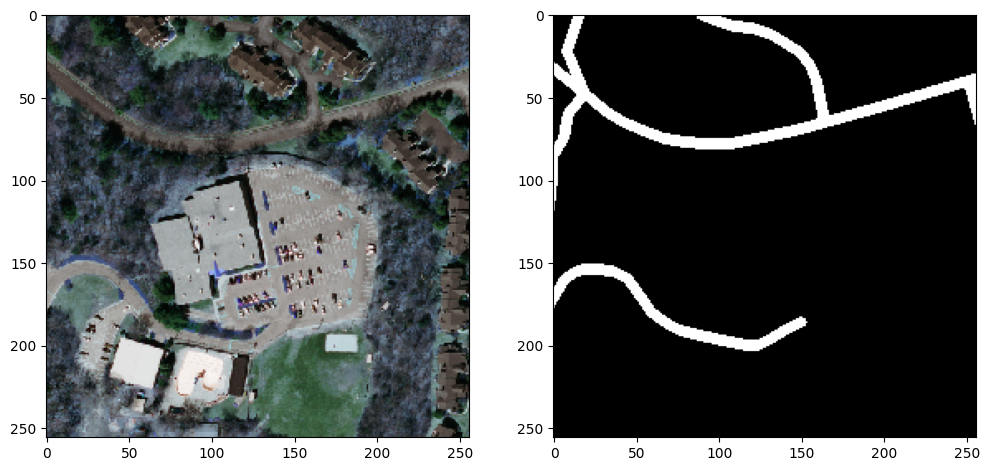

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

###Model Architecture:
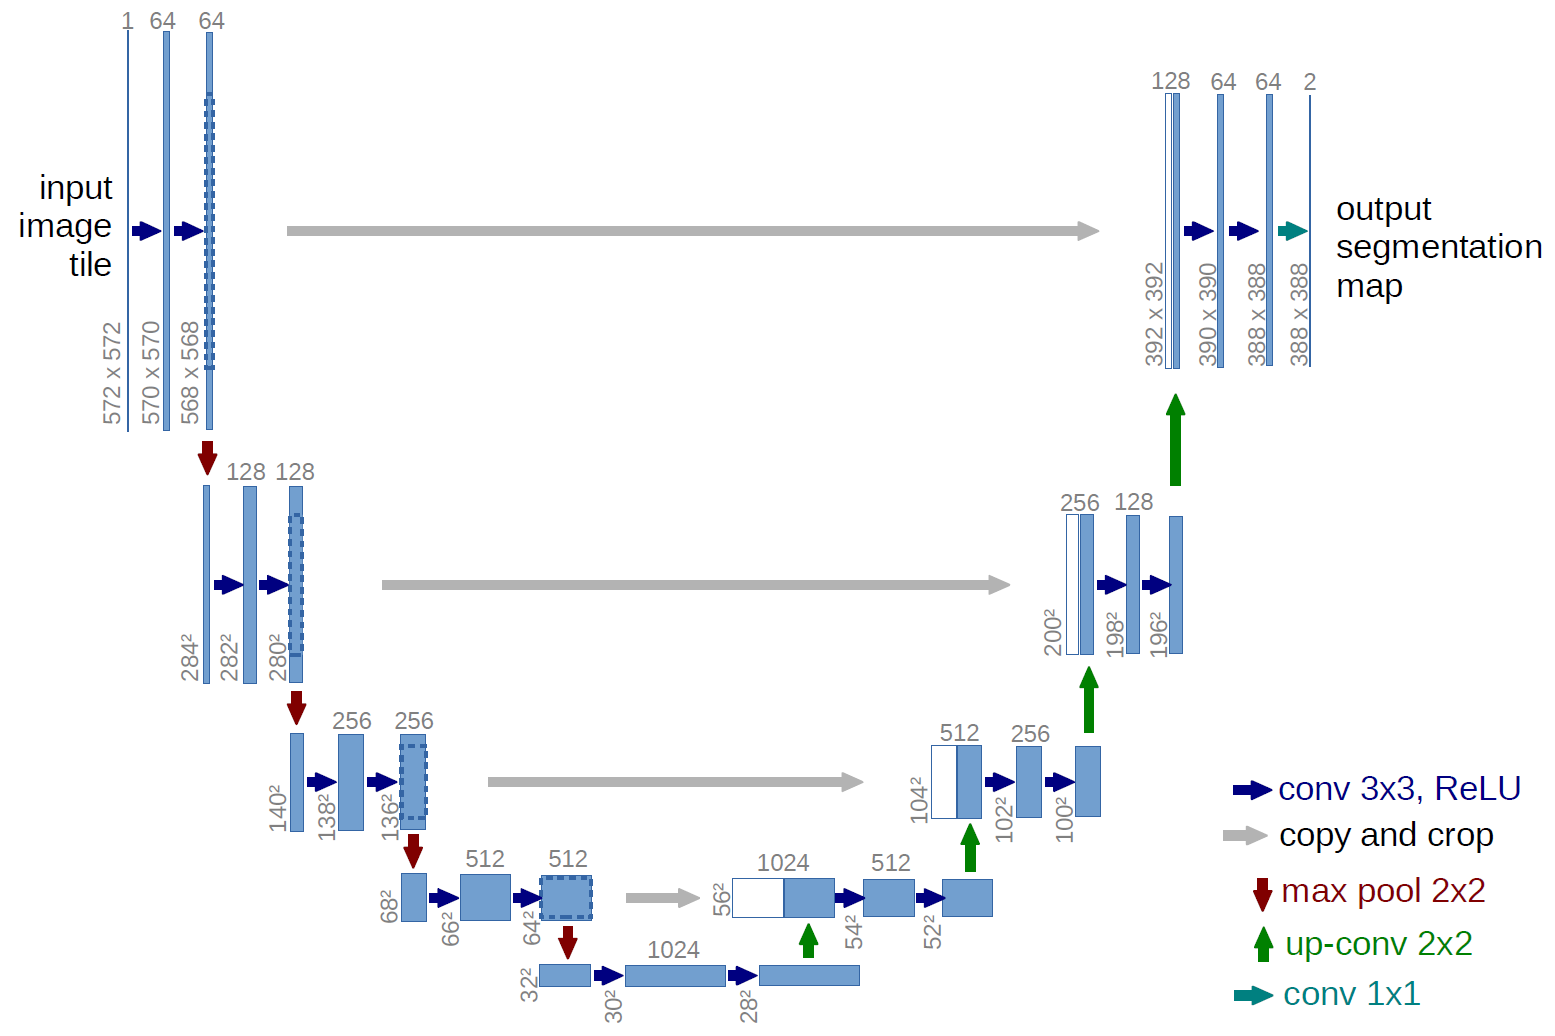

The provided code implements a U-Net model for image segmentation. The U-Net architecture consists of an encoder and decoder, divided into blocks, allowing for effective feature extraction and localization. Here's a brief description of the model and how it relates to the problem statement:

1. Encoder Block: The encoder block performs convolutional operations followed by max pooling, downsampling the input image while capturing relevant features. It helps in extracting hierarchical features from the input image.

2. Convolutional Block: The conv_block function applies two convolutional layers with batch normalization and activation functions (ReLU) to capture and enhance the image features effectively.

3. Decoder Block: The decoder block performs upscaling of the feature maps using transpose convolutions. It also concatenates skip connections from the corresponding encoder block to recover spatial information lost during the downsampling process.

4. Bridge: The bridge connects the encoder and decoder blocks by applying another convolutional block. It helps in maintaining the flow of information and preserving crucial features.

5. Output: The final decoder block produces the segmentation output. The number of classes determines the activation function used: sigmoid for binary segmentation or softmax for multiclass segmentation.

The U-Net model helps address the problem statement of road image segmentation by accurately identifying and segmenting road regions from satellite imagery. The model can effectively capture spatial and contextual information from the images. The model's ability to learn intricate features and understand road patterns will enable the creation of data masks for road segmentation. This information can be leveraged for urban planning, transportation analysis, and environmental impact assessment, providing valuable insights into road networks and their implications on the environment.

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

The model summary provides a detailed overview of the architecture of the U-Net model used for binary image segmentation. Here's a breakdown of the model summary and the trained parameters:

The input layer takes images of size 256x256 with 3 channels (RGB).

The output shape of the model is (None, 256, 256, 1), where None represents the batch size.

The total number of trainable parameters in the model is 31,043,521. These are the weights and biases that the model learns during the training process to make predictions. The non-trainable parameters (11,776) represent the parameters of the batch normalization layers, which are not updated during training.

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

###Training and Evaluation:
The model will be trained using the training set and validated using the validation set. The training process will involve optimizing hyperparameters, such as learning rate, batch size, and data augmentation techniques to achieve the best performance. The model will be evaluated using metrics such as accuracy, precision, recall, and F1 score, and compared with other state-of-the-art methods for performance analysis.

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    verbose=1,
                    epochs=50,
                    shuffle=True)

Epoch 1/50
206/206 [==============================] - 147s 614ms/step - loss: 0.1791 - accuracy: 0.9416
Epoch 2/50
206/206 [==============================] - 125s 609ms/step - loss: 0.1342 - accuracy: 0.9516
Epoch 3/50
206/206 [==============================] - 126s 610ms/step - loss: 0.1234 - accuracy: 0.9553
Epoch 4/50
206/206 [==============================] - 126s 611ms/step - loss: 0.1139 - accuracy: 0.9590
Epoch 5/50
206/206 [==============================] - 126s 609ms/step - loss: 0.1041 - accuracy: 0.9625
Epoch 6/50
206/206 [==============================] - 126s 612ms/step - loss: 0.0951 - accuracy: 0.9660
Epoch 7/50
206/206 [==============================] - 126s 611ms/step - loss: 0.0892 - accuracy: 0.9683
Epoch 8/50
206/206 [==============================] - 126s 611ms/step - loss: 0.0887 - accuracy: 0.9686
Epoch 9/50
206/206 [==============================] - 126s 613ms/step - loss: 0.0839 - accuracy: 0.9702
Epoch 10/50
206/206 [==============================] - 127s 615m

###Save model and Analyze results:
The results of the trained model will be presented, showcasing the accuracy and efficiency of the proposed U-Net model for binary road segmentation.

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/Model/road_model1.hdf5')

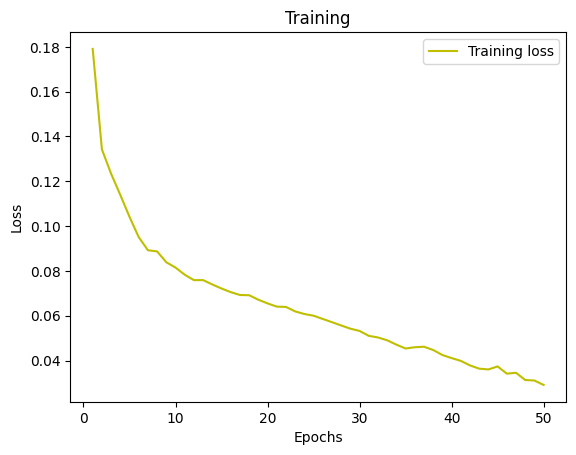

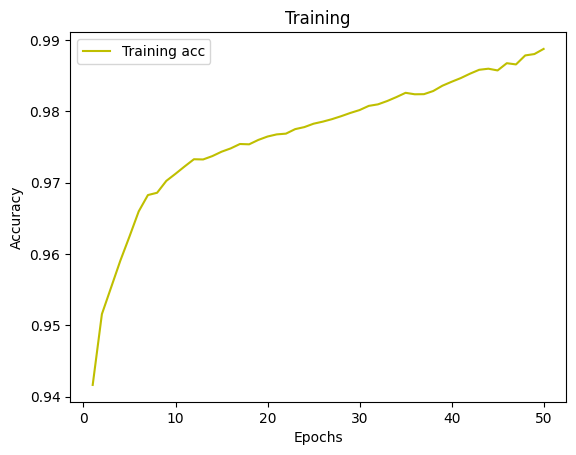

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/PORTFOLIO/Ariel-binary-segmentation/Model/road_model1.hdf5", compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

17/17 [==============================] - 1197s 70s/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7755836


###Conclusion

In conclusion, the proposed U-Net model has been developed for the task of image segmentation to identify and map roads from satellite images. The model was trained on a dataset of satellite images, cropped to 256x256 pixels, and corresponding road masks. By dividing the encoder and decoder into blocks, the model effectively captures spatial information and performs feature extraction. The model's performance was evaluated on a test set, and the generated road masks were compared to the ground truth masks. By thresholding the prediction at 0.5, the model produces binary road masks. The visual comparison of the predicted masks with the ground truth masks allows for an assessment of the model's accuracy in road segmentation. This approach has significant implications for modern environmental analysis as it enables the creation of data masks for road segmentation from satellite imagery. The accurate identification and mapping of roads can provide valuable insights into transportation infrastructure planning, urban development, and environmental impact assessments.

(1, 256, 256, 3)
1/1 [==============================] - 2s 2s/step
(256, 256)


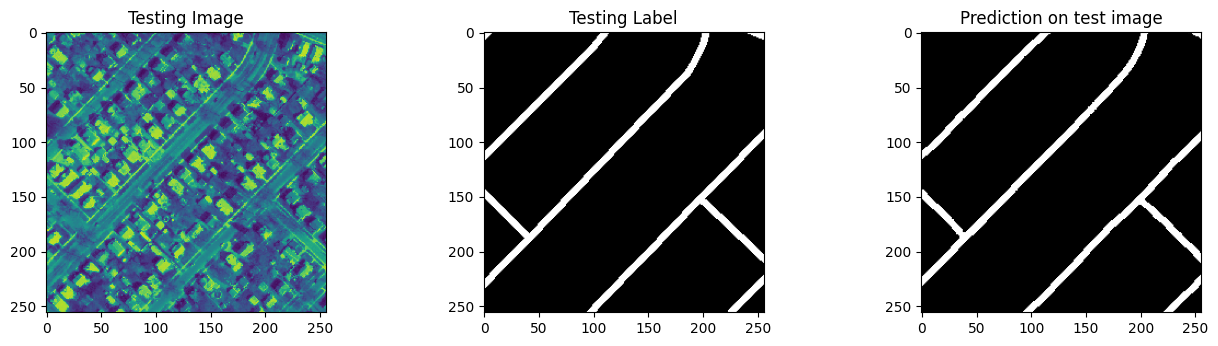

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()